In [1]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing
from scipy.stats import iqr
import tensorflow as tf

# Pre processing

In [2]:
path = '/anomalyvol/data/events_LHCO2020_backgroundMC_Pythia.h5'

In [19]:
df = pd.read_hdf(path,stop=10000) # just read first 10000 events

In [20]:
all_events = df.values

In [21]:
rows = all_events.shape[0]
cols = all_events.shape[1]
data = []
# more_data
data2 = []
print(rows, cols)

10000 2100


In [22]:
nparts = []
for i in range(rows):
    pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
    for j in range(cols // 3):
        if (all_events[i][j*3]>0):
            pseudojets_input[j]['pT'] = all_events[i][j*3]
            pseudojets_input[j]['eta'] = all_events[i][j*3+1]
            pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        pass
    # cluster jets from the particles in one observation
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    for k in range(len(jets)): # for each jet get (px, py, pz, e)
        if jets[k].pt < 200: continue
        particles = np.zeros((100,4))
        nparts.append(len(jets[k]))
        for p, part in enumerate(jets[k]):
            if p >= 100: break
            particles[p,:] = np.array([part.px,
                                       part.py,
                                       part.pz,
                                       part.e])
        data.append(particles)
print(data)
print(np.mean(nparts))
print(np.max(nparts))
print(np.min(nparts))
print(np.percentile(nparts, 95))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [23]:
data = np.stack(data,axis=0)
print(data.shape)
print(data)

(24043, 100, 4)
[[[-4.53540316 -1.26489676  6.25380246  7.82814735]
  [-1.29560759 -0.02328982  1.41958818  1.92207493]
  [-0.68179651 -1.17327202  0.73898564  1.54515808]
  ...
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.15441286  0.31261169  0.13826326  0.3750815 ]
  [ 2.21352603  0.95378217  2.51937375  3.48663764]
  [ 0.81016925  0.43543171  0.40410066  1.00462547]
  ...
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 4.95538828 -1.92603623 11.14609147 12.34912319]
  [ 0.40725781  0.1808598   2.26965288  2.31298366]
  [ 1.68009995  0.60353411  4.741078    5.0660448 ]
  ...
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 ...

 [[-0.07010023 -0.

In [61]:
# splitting data
x_train = data[0:int(len(data) * 0.8)]
x_val = data[int(len(data) * 0.8):int(len(data) * 0.9)]
x_test = data[int(len(data) * 0.9):]

In [66]:
# regularize (skip for now)
scaler = preprocessing.StandardScaler()
x_train_reshape = scaler.fit_transform(x_train.reshape((-1,4)))
x_val_reshape = scaler.transform(x_val.reshape((-1,4)))
x_test_reshape = scaler.transform(x_test.reshape((-1,4)))
x_train = x_train_reshape.reshape(-1,100,4)
x_val = x_val_reshape.reshape(-1,100,4)
x_test = x_test_reshape.reshape(-1,100,4)
print(x_train)

[[[-1.36591596e-01 -3.81444476e-02  1.36415940e-01 -1.10782085e-01]
  [-3.90044370e-02 -7.93839132e-04  3.20091069e-02 -2.02709628e-01]
  [-2.05155919e-02 -3.53881488e-02  1.73098089e-02 -2.08576308e-01]
  ...
  [ 2.10693726e-05 -9.32235807e-05  1.34958326e-03 -2.32626570e-01]
  [ 2.10693726e-05 -9.32235807e-05  1.34958326e-03 -2.32626570e-01]
  [ 2.10693726e-05 -9.32235807e-05  1.34958326e-03 -2.32626570e-01]]

 [[ 4.67219992e-03  9.31090958e-03  4.33572095e-03 -2.26788457e-01]
  [ 6.66955586e-02  2.85989040e-02  5.57617009e-02 -1.78357335e-01]
  [ 2.44244966e-02  1.30056395e-02  1.00771382e-02 -2.16989655e-01]
  ...
  [ 2.10693726e-05 -9.32235807e-05  1.34958326e-03 -2.32626570e-01]
  [ 2.10693726e-05 -9.32235807e-05  1.34958326e-03 -2.32626570e-01]
  [ 2.10693726e-05 -9.32235807e-05  1.34958326e-03 -2.32626570e-01]]

 [[ 1.49284271e-01 -5.80331586e-02  2.42077041e-01 -4.04134583e-02]
  [ 1.22882422e-02  5.34748673e-03  5.03683600e-02 -1.96625165e-01]
  [ 5.06280217e-02  1.80625756e-

In [68]:
# make graph representation
import keras
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Lambda, Conv1D, SpatialDropout1D, Concatenate, Flatten, Reshape
import keras.backend as K
from keras.backend import slice

def conv(nconvs, nconvinputs):

    inputs_conv = Input(shape=(nconvs, nconvinputs,), name = 'input_conv')

    y = Conv1D(filters=32, kernel_size=(1,), strides=(1,), padding='same', 
               kernel_initializer='he_normal', use_bias=True, name='conv_1',
               activation = 'relu')(inputs_conv)

    y = Lambda(lambda x: K.mean(x, axis=-2), name = 'lambda_1', input_shape=(nconvs,32)) (y) 
                 
    y = Dense(nconvs*32, name = 'dense_1', activation='relu', kernel_initializer='glorot_uniform')(y)
    y = Reshape((nconvs, 32), name = 'reshape_1')(y)
    outputs = Conv1D(filters=4, kernel_size=(1,), strides=(1,), padding='same', 
               kernel_initializer='he_normal', use_bias=True, name='output',
               activation = 'linear')(y)

    keras_model = Model(inputs=inputs_conv, outputs=outputs)
    
    return keras_model
    
keras_model = conv(100, 4)
print(keras_model.summary())

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_conv (InputLayer)      (None, 100, 4)            0         
_________________________________________________________________
conv_1 (Conv1D)              (None, 100, 32)           160       
_________________________________________________________________
lambda_1 (Lambda)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3200)              105600    
_________________________________________________________________
reshape_1 (Reshape)          (None, 100, 32)           0         
_________________________________________________________________
output (Conv1D)              (None, 100, 4)            132       
Total params: 105,892
Trainable params: 105,892
Non-trainable params: 0
_____________________________________________________

In [116]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10,monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, 
                                      mode='min', verbose=1, epsilon=0.001,
                                      cooldown=4, min_lr=1e-5)
]
opt = keras.optimizers.Adadelta(lr=0.0001)
keras_model.compile(loss='mse',optimizer=opt)
history = keras_model.fit(x_train, x_train,
                          epochs=300,
                          shuffle=True,
                          callbacks=my_callbacks,
                          validation_data = (x_val,x_val),
                          batch_size = 1024)

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 19234 samples, validate on 2404 samples
Epoch 1/300
19234/19234 [==============================] - 0s 15us/step - loss: 0.8615 - val_loss: 0.9247
Epoch 2/300
19234/19234 [==============================] - 0s 6us/step - loss: 0.8615 - val_loss: 0.9247

Epoch 00002: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 3/300
19234/19234 [==============================] - 0s 6us/step - loss: 0.8615 - val_loss: 0.9247
Epoch 4/300
19234/19234 [==============================] - 0s 6us/step - loss: 0.8615 - val_loss: 0.9247
Epoch 5/300
19234/19234 [==============================] - 0s 6us/step - loss: 0.8615 - val_loss: 0.9247
Epoch 6/300
19234/19234 [==============================] - 0s 6us/step - loss: 0.8615 - val_loss: 0.9247

Epoch 00006: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 7/300
19234/19234 [==============================] - 0s 6us/step - loss: 0.8615 - val_loss: 0.9247
Epoch 8/300
19234/19234 [============================

In [150]:
predict = keras_model.predict(x_test)
i = 3 # px
dx = ((predict[:,i] - x_test[:,i])/x_test[:,i]).flatten()

(array([ 10.,  14.,  16.,  14.,  14.,  11.,  14.,  20.,  20.,  12.,  12.,
         17.,  18.,  20.,  27.,  19.,  30.,  26.,  35.,  32.,  34.,  39.,
         35.,  49.,  72.,  79.,  80.,  77.,  80.,  94.,  94., 101., 102.,
         94., 114., 112., 108., 138., 133., 133., 169., 179., 200., 194.,
        257., 224., 249., 203., 204., 173., 143., 131.,  97.,  95.,  95.,
         77.,  93.,  66.,  71.,  68.,  70.,  48.,  67.,  55.,  53.,  59.,
         48.,  39.,  53.,  54.,  46.,  44.,  37.,  35.,  31.,  28.,  33.,
         46.,  39.,  45.,  40.,  24.,  44.,  40.,  44.,  42.,  38.,  30.,
         31.,  36.,  30.,  31.,  26.,  28.,  36.,  22.,  32.,  26.,  27.,
         16.]),
 array([-2.  , -1.96, -1.92, -1.88, -1.84, -1.8 , -1.76, -1.72, -1.68,
        -1.64, -1.6 , -1.56, -1.52, -1.48, -1.44, -1.4 , -1.36, -1.32,
        -1.28, -1.24, -1.2 , -1.16, -1.12, -1.08, -1.04, -1.  , -0.96,
        -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68, -0.64, -0.6 ,
        -0.56, -0.52, -0.48, -0.44

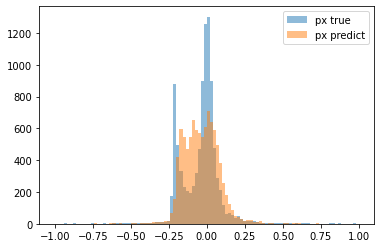

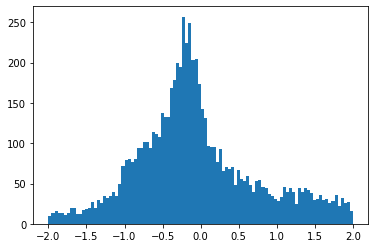

In [151]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(x_test[:,i].flatten(),bins=np.linspace(-1,1,101),alpha=0.5,label='px true')
plt.hist(predict[:,i].flatten(),bins=np.linspace(-1,1,101),alpha=0.5,label='px predict')
plt.legend()
plt.figure()
plt.hist(dx,bins=np.linspace(-2,2,101))

Text(0, 0.5, 'px predict')

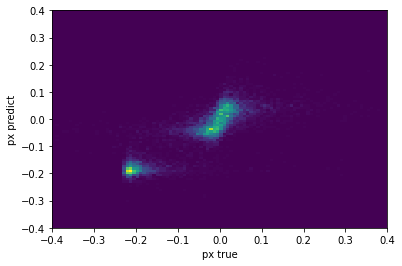

In [149]:
plt.hist2d(x_test[:,i].flatten(), predict[:,i].flatten(), bins=(np.linspace(-0.4,0.4,101), np.linspace(-0.4,0.4,101)) )
plt.xlabel('px true')
plt.ylabel('px predict')